# Context-Dependent Decision Making Task

This environment implements a context-dependent perceptual decision-making task, in which the agent has to perform a perceptual decision that depends on a context that is explicitly indicated on each trial. The environment is a simplified version of the original task ([Mante et al. 2013](https://www.nature.com/articles/nature12742)), that tests the agents' ability to flexibly switch between different contexts by making them choose between two options (left or right) based on the stimulus evidence associated with the relevant context (e.g., motion and color). The key features of the task are:

1. The relevant context is explicitly signaled on each trial.
2. Choices are represented as angles evenly spaced around a circle. Note that the number of choices can be configured via `dim_ring`. With the default of 2 choices, this corresponds to:

   - Position 1: 0° (left choice)
   - Position 2: 180° (right choice)

3. Stimulus for each context is represented as a cosine modulation peaked at one of these positions.
4. The correct choice (ground truth) is randomly chosen on each trials (for 2 choices: left or right).
5. The stimulus evidence (coherence) of each context is also randomly chosen on each trial.

For example, if the context signal indicates modality 0, the agent must:

- Choose position 1 (left) when context 0's coherence peaks at 0°
- Choose position 2 (right) when context 0's coherence peaks at 180°

In this notebook, we will:

1. Train an agent on the task using supervised learning and reinforcement learning with [Stable-Baselines3](https://stable-baselines3.readthedocs.io/).
2. Compare the behavior of agents trained with supervised learning and reinforcement learning.


# 0. Install Dependencies

To begin, install the `neurogym` package. This will automatically install all required dependencies, including Stable-Baselines3.

For detailed instructions on how to install `neurogym` within a conda environment or in editable mode, refer to the [installation instructions](https://github.com/neurogym/neurogym?tab=readme-ov-file#installation).


In [ ]:
# Uncomment to install
# ! pip install neurogym[rl]

# 1. Training an Agent on the Context-Dependent Decision Making Task


## 1.1 Environment Setup and Initial Agent Behavior

Let's now create and explore the environment using the `ContextDecisionMaking` class from neurogym. We'll use the default configuration for explicit context mode (`use_expl_context = True`) which includes:

- `dim_ring = 2`: Two possible choices (left/right) represented at 0° and 180°. Note that the ring architecture can support any number of choices, making it suitable for more complex decision-making scenarios. The environment will provide context signals indicating which modality is relevant for each trial, allowing the agent to flexibly adapt its decision strategy.
- `timing = {'fixation': 300, 'stimulus': 750, 'delay': ~600, 'decision': 100}` (in milliseconds).
- `rewards = {'abort': -0.1, 'correct': +1.0}`; abort is a penalty applied when the agent fails to fixate. The task allows the trial to be aborted if fixation does not occur, which is where the name of this penalty comes from.
- `sigma = 1.0`: Standard deviation of the noise added to the inputs.


### 1.1.1 Import Libraries


In [4]:
import warnings
import matplotlib.pyplot as plt
import scipy
import numpy as np
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
from neurogym.utils import plot_env
import gymnasium as gym
import os
import sys
from neurogym.wrappers.monitor import Monitor
import torch.nn as nn
import torch

warnings.filterwarnings("ignore")

### 1.1.2 Environment Setup


In [2]:
# Environment parameters
EVAL_TRIALS = 1000
dt = 100
dim_ring = 2  # Number of choices in the ring representation
rewards = {
    "abort": -0.1,
    "correct": +1.0,
    "fail": 0.0
}
sigma = 1.0 # Standard deviation of the Gaussian noise in the ring representation

Trial timing (in milliseconds):
{'fixation': ('uniform', (200, 500)), 'stimulus': ('choice', [200, 400, 600]), 'decision': 200}

Observation space structure:
Box(-inf, inf, (5,), float32)

Action space structure:
Discrete(3)
Action mapping:
{'fixation': 0, 'choice': range(1, 3)}


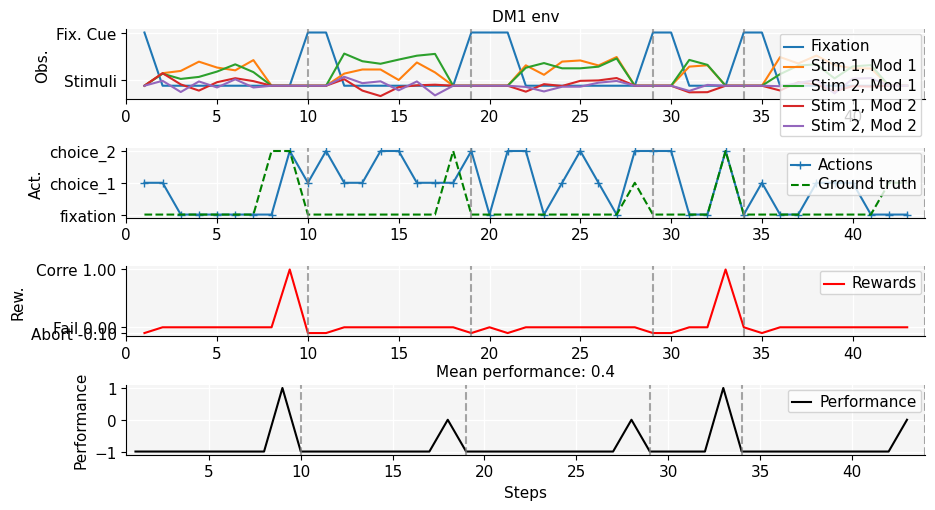

In [5]:
### dm1
timing = {
    "fixation": ("uniform", (200, 500)),
    "stimulus": ("choice", [200, 400, 600]),
    "decision": 200,
}
kwargs = {
    "dt": dt,
    "dim_ring": dim_ring,
    "rewards": rewards,
    "timing": timing,
    "sigma": sigma,
}
task = 'dm1'
task = f"yang19.{task}-v0"
env_dm = gym.make(task, **kwargs)

# Print environment specifications
print("Trial timing (in milliseconds):")
print(env_dm.timing)

print("\nObservation space structure:")
print(env_dm.observation_space)

print("\nAction space structure:")
print(env_dm.action_space)
print("Action mapping:")
print(env_dm.action_space.name)

obs, info = env_dm.reset()

stim1 = [f'Stim {i}, Mod 1' for i in range(1, kwargs['dim_ring'] + 1)]
stim2 = [f'Stim {i}, Mod 2' for i in range(1, kwargs['dim_ring'] + 1)]

# Visualize example trials
fig = plot_env(
    env_dm,
    name='DM1',
    ob_traces=['Fixation'] + stim1 + stim2,
    num_trials=5,
    plot_performance=True,
    fig_kwargs={'figsize': (9, 5)},
)

for text_obj in fig.findobj(match=plt.Text):
    text_obj.set_fontsize(11)
fig.savefig(f"untrained_{task}.pdf", dpi=300, bbox_inches='tight')

Trial timing (in milliseconds):
{'fixation': ('uniform', (200, 500)), 'stimulus': 500, 'decision': 200}

Observation space structure:
Box(-inf, inf, (5,), float32)

Action space structure:
Discrete(3)
Action mapping:
{'fixation': 0, 'choice': range(1, 3)}


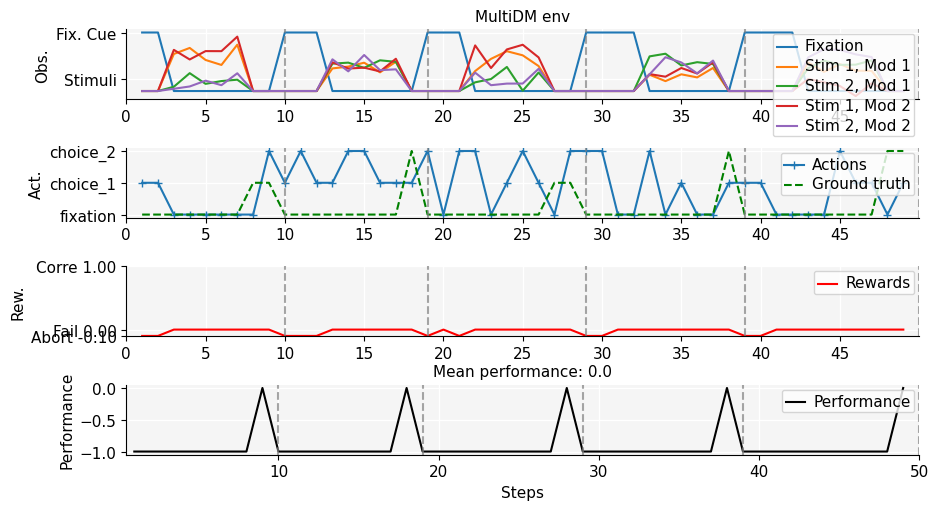

In [ ]:
### multidm
timing = {
    "fixation": ("uniform", (200, 500)),
    "stimulus": 500,
    "decision": 200,
}
kwargs = {
    "dt": dt,
    "dim_ring": dim_ring,
    "rewards": rewards,
    "timing": timing,
    "sigma": sigma,
}
task = 'multidm'
task = f"yang19.{task}-v0"
env_multidm = gym.make(task, **kwargs)

# Print environment specifications
print("Trial timing (in milliseconds):")
print(env_multidm.timing)

print("\nObservation space structure:")
print(env_multidm.observation_space)

print("\nAction space structure:")
print(env_multidm.action_space)
print("Action mapping:")
print(env_multidm.action_space.name)

obs, info = env_multidm.reset()

stim1 = [f'Stim {i}, Mod 1' for i in range(1, kwargs['dim_ring'] + 1)]
stim2 = [f'Stim {i}, Mod 2' for i in range(1, kwargs['dim_ring'] + 1)]

# Visualize example trials
fig = plot_env(
    env_multidm,
    name='MultiDM',
    ob_traces=['Fixation'] + stim1 + stim2,
    num_trials=5,
    plot_performance=True,
    fig_kwargs={'figsize': (9, 5)},
)

for text_obj in fig.findobj(match=plt.Text):
    text_obj.set_fontsize(11)
fig.savefig(f"untrained_{task}.pdf", dpi=300, bbox_inches='tight')

In [7]:
# Environment parameters
EVAL_TRIALS = 1000
kwargs = {'dt': 100, 'dim_ring': 2}
seq_len = 100

# Make supervised dataset
tasks = ngym.get_collection('yang19')
envs = [gym.make(task, **kwargs) for task in tasks]
schedule = RandomSchedule(len(envs))
env = ScheduleEnvs(envs, schedule=schedule, env_input=True)

# Print environment specifications
print("Trial timing (in milliseconds):")
print(env.timing)

print("\nObservation space structure:")
print(env.observation_space)

print("\nAction space structure:")
print(env.action_space)
print("Action mapping:")
print(env.action_space.name)

Trial timing (in milliseconds):
{'fixation': 500, 'stimulus': 500, 'delay': 0, 'decision': 500}

Observation space structure:
Box(-inf, inf, (25,), float32)

Action space structure:
Discrete(3)
Action mapping:
{'fixation': 0, 'choice': range(1, 3)}


### 1.1.3 Random Agent Behavior

Let's now plot the behavior of a random agent on the task. The agent will randomly choose between the two options (left/right, blue line), and we will visualize its behavior over 5 trials. We will also plot the reward received by the agent at each time step, as well as the performance on each trial. Note that performance is only defined at the end of a trial: it is 1 if the agent made the correct choice, and 0 otherwise.

To keep track of the agent's behavior, we will use the `Monitor` wrapper, which monitors training by:

- Tracking and saving behavioral data (rewards, actions, observations) every `sv_per` steps.
- Generating visualization figures during training if` sv_fig=True`.
- Providing progress information if `verbose=True`.

Here, we’ll use the wrapper solely to compute the agent’s performance, but later it will help us assess learning and save intermediate results.


Neurogym | 2025-06-20@16:03:23 | Completed 1000/1000 trials



Evaluating random policy performance...

Random policy metrics (1,000 trials):
Mean performance: 0.4440
Mean reward: 0.4440


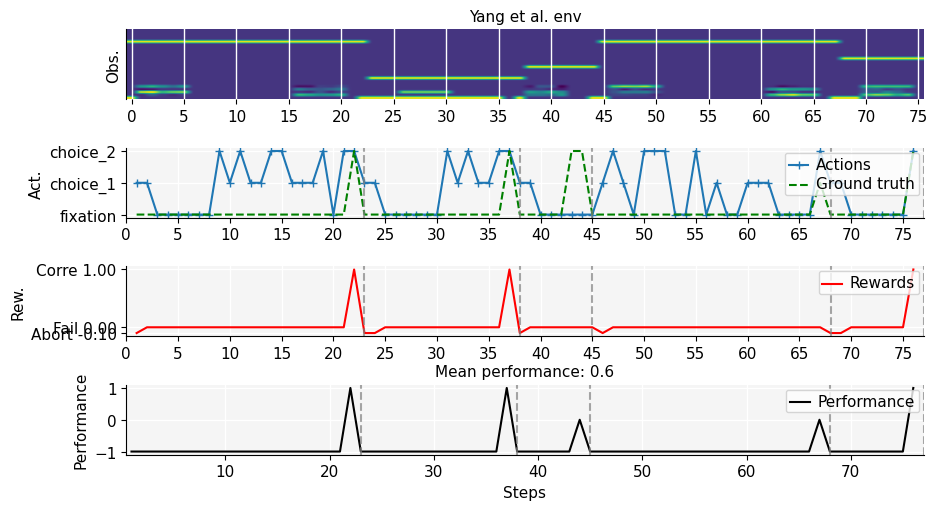

In [9]:
obs, info = env.reset()

# Visualize example trials
from neurogym.utils.plotting import plot_env as plot_env_orig

fig = plot_env_orig(
    env,
    name='Yang et al.',
    ob_traces=None,
    num_trials=5,
    plot_performance=True,
    fig_kwargs={'figsize': (9, 5)},
)
for text_obj in fig.findobj(match=plt.Text):
    text_obj.set_fontsize(11)
fig.savefig("untrained_env.pdf", dpi=300, bbox_inches='tight')

# Evaluate performance of random policy
eval_monitor = Monitor(env)
print("\nEvaluating random policy performance...")
metrics = eval_monitor.evaluate_policy(num_trials=EVAL_TRIALS)
print(f"\nRandom policy metrics ({EVAL_TRIALS:,} trials):")
print(f"Mean performance: {metrics['mean_performance']:.4f}")
print(f"Mean reward: {metrics['mean_reward']:.4f}")

As we can see, the agent's behavior is entirely random. It does not learn to fixate or to choose the correct option based on contextual cues. As a result, its performance is also random. Through training, we expect the agent to improve by learning to respect the fixation period, use context cues to infer the relevant context, and map signal peaks to the correct choices in the ring representation. Let’s move on to training the agent to see whether it can learn these key aspects of the task.


# 2. Learning the Task as a Supervised Problem

We will now train the agent using supervised learning. NeuroGym provides functionality to generate a dataset directly from the environment, allowing us to sample batches of inputs and corresponding labels for training.


## 2.1 Converting the Environment to a Supervised Dataset


### 2.1.1 Dataset Setup


In [10]:
seq_len = 100
print(f"Using sequence length: {seq_len}")

# Make supervised dataset
batch_size = 32
print(f"Creating dataset with batch_size={batch_size}")
dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len)

env = dataset.env

# Extract dimensions
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {ob_size}") # 20 one hot env encoding, 1 fixation, 2 mod 1, 2 mod 2
print(f"Action size: {act_size}")

# Get a batch of data
inputs, target = dataset()
print(f"Input batch shape: {inputs.shape}")
print(f"Target batch shape: {target.shape}")

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using sequence length: 100
Creating dataset with batch_size=32
Observation size: 25
Action size: 3
Input batch shape: (100, 32, 25)
Target batch shape: (100, 32)
Using device: cpu


### 2.1.2 Model Setup


In [16]:
# Define the LSTM model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=False)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        output = self.fc(lstm_out)
        return output, hidden

    def init_hidden(self, batch_size, device):
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        return (h0, c0)

# Create the model
hidden_size = 128
sl_model = Net(
    input_size=ob_size,
    hidden_size=hidden_size,
    output_size=act_size,
).to(device)

## 2.2 Training and Evaluating a Neural Network Model


### 2.2.1 Training the Model


Epoch [0/1000], Loss: 1.0885
Epoch [100/1000], Loss: 0.1555
Epoch [200/1000], Loss: 0.0887
Epoch [300/1000], Loss: 0.0760
Epoch [400/1000], Loss: 0.0478
Epoch [500/1000], Loss: 0.0222
Epoch [600/1000], Loss: 0.0381
Epoch [700/1000], Loss: 0.0280
Epoch [800/1000], Loss: 0.0212
Epoch [900/1000], Loss: 0.0233
Finished Training


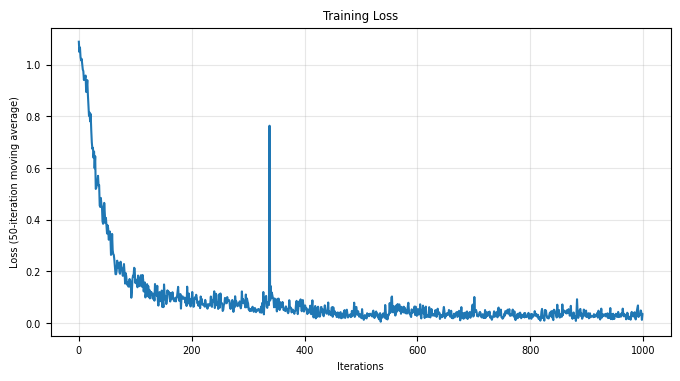

In [17]:
# This setting is low to speed up testing, we recommend setting it to at least 1000
EPOCHS = 1000

# This weighting deprioritizes class 0 while keeping the other 16 classes equally important,
# aligning with the reward distribution idea from the RL setting
class_weights = torch.tensor([0.05] + [1.0]*(act_size - 1)).to(device)
# Define the optimizer and loss function
optimizer = torch.optim.Adam(sl_model.parameters(), lr=0.01, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
loss_history = []

for i in range(EPOCHS):
    # Get a batch of data
    inputs, targets = dataset()

    # Convert to PyTorch tensors
    inputs = torch.from_numpy(inputs).float().to(device)
    targets = torch.from_numpy(targets).long().to(device)

    # Initialize hidden state
    hidden = sl_model.init_hidden(inputs.size(1), device)

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass with hidden state tracking
    outputs, _ = sl_model(inputs, hidden)

    # Reshape for CrossEntropyLoss
    outputs_flat = outputs.reshape(-1, outputs.size(2))
    targets_flat = targets.reshape(-1)

    # Calculate loss
    # Weight the loss to account for class imbalance (very low weight to 0s, higher weights to 1s and 2s)
    loss = criterion(outputs_flat, targets_flat)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # print statistics
    loss_history.append(loss.item())
    if i % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(i, EPOCHS, loss.item()))

print('Finished Training')

# Plot the loss curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (50-iteration moving average)')
plt.grid(True, alpha=0.3)
plt.show()

### 2.2.2 Evaluate the Model's Performance


In [20]:
verbose = False
# Evaluate performance of the trained model
sl_model.eval()
# Initialize storage for each environment
sl_mean_performance = {}
for e_i in env.envs:
    sl_mean_performance[e_i.spec.id] = []

# Evaluate for specified number of trials
print(f"Evaluating model performance across {EVAL_TRIALS} trials...\n")

for env_idx, e_i in enumerate(env.envs):
    data = {"action": [], "gt": [], "trial": []}
    total_correct = 0
    for trial_idx in range(EVAL_TRIALS):
        trial = e_i.new_trial()
        data["trial"].append(trial)
        ob, gt = e_i.ob, e_i.gt
        data["gt"].append(gt[-1])
        trial_length = ob.shape[0]

        # Add one-hot encoding for the environment
        env_one_hot = np.zeros((trial_length, len(env.envs)))
        env_one_hot[:, env_idx] = 1.0  # Set the current environment index to 1

        # Concatenate original observation with one-hot encoding
        ob_with_env = np.concatenate([ob, env_one_hot], axis=1)

        ob_with_env = ob_with_env[:, np.newaxis, :]  # Add batch dimension

        inputs = torch.from_numpy(ob_with_env).float().to(device)
        hidden = sl_model.init_hidden(1, device)

        with torch.no_grad():
            outputs, _ = sl_model(inputs, hidden)
            pred_actions = torch.argmax(outputs, dim=2)
            data["action"].append(pred_actions[-1, 0].cpu().numpy())

        decision_idx = trial_length - 1
        is_correct = (gt[decision_idx] == pred_actions[decision_idx, 0].cpu().numpy())
        total_correct += is_correct

    accuracy = total_correct / EVAL_TRIALS
    sl_mean_performance[e_i.spec.id].append(accuracy)
    for key in data:
        if key != "trial":
            data[key] = np.array(data[key])


# Print average performance
print("Average performance across all environments:")
for e_i in env.envs:
    mean_acc = np.mean(sl_mean_performance[e_i.spec.id])
    print(f"{e_i.spec.id}: {mean_acc:.4f}")

Evaluating model performance across 1000 trials...

Average performance across all environments:
yang19.go-v0: 1.0000
yang19.rtgo-v0: 1.0000
yang19.dlygo-v0: 1.0000
yang19.anti-v0: 1.0000
yang19.rtanti-v0: 1.0000
yang19.dlyanti-v0: 1.0000
yang19.dm1-v0: 0.9300
yang19.dm2-v0: 0.9130
yang19.ctxdm1-v0: 0.9420
yang19.ctxdm2-v0: 0.9410
yang19.multidm-v0: 0.8940
yang19.dlydm1-v0: 0.9930
yang19.dlydm2-v0: 1.0000
yang19.ctxdlydm1-v0: 0.9990
yang19.ctxdlydm2-v0: 0.9980
yang19.multidlydm-v0: 0.8970
yang19.dms-v0: 1.0000
yang19.dnms-v0: 1.0000
yang19.dmc-v0: 1.0000
yang19.dnmc-v0: 1.0000
